In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 🚀 Clean, wandb-free contrastive fine-tuning

from sentence_transformers import SentenceTransformer, InputExample, losses, models
from torch.utils.data import DataLoader
import pandas as pd
import torch

# -----------------------------
# 1️⃣ LOAD DATA (using prompt column)
# -----------------------------
train_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/train/generated_harmless_4000.csv")
train_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/train/train_harmful_4000.csv")
test_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmless_2000.csv")
test_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmful_2000.csv")

print(f"✅ Train: {len(train_harmless) + len(train_harmful)} | Test: {len(test_harmless) + len(test_harmful)}")

# -----------------------------
# 2️⃣ CREATE CONTRASTIVE PAIRS
# -----------------------------
train_examples = []

for i in range(min(len(train_harmless), len(train_harmful))):
    # Harmless–Harmful (negative pair)
    train_examples.append(InputExample(
        texts=[str(train_harmless.iloc[i]["prompt"]), str(train_harmful.iloc[i]["prompt"])],
        label=0.0
    ))

    # Harmless–Harmless (positive pair)
    if i < len(train_harmless) - 1:
        train_examples.append(InputExample(
            texts=[str(train_harmless.iloc[i]["prompt"]), str(train_harmless.iloc[i+1]["prompt"])],
            label=1.0
        ))

print(f"✅ Created {len(train_examples)} contrastive pairs")

# -----------------------------
# 3️⃣ MODEL SETUP
# -----------------------------
embedding_model = models.Transformer('bert-base-uncased')
pooling_model = models.Pooling(embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[embedding_model, pooling_model])

train_loss = losses.CosineSimilarityLoss(model)

# -----------------------------
# 4️⃣ TRAINING (A100 optimized)
# -----------------------------
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)
num_epochs = 3
warmup_steps = int(0.1 * len(train_dataloader))

torch.set_float32_matmul_precision('high')

# ✅ No W&B. No external logging.
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    show_progress_bar=True,
    use_amp=True,
    output_path="./contrastive_bert_clean"
)

print("✅ Training complete — model saved to './contrastive_bert_clean'")


✅ Train: 8000 | Test: 4000
✅ Created 7999 contrastive pairs


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samiradeepak (samiradeepak-svkm-s-narsee-monjee-institute-of-managemen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.005500


✅ Training complete — model saved to './contrastive_bert_clean'


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


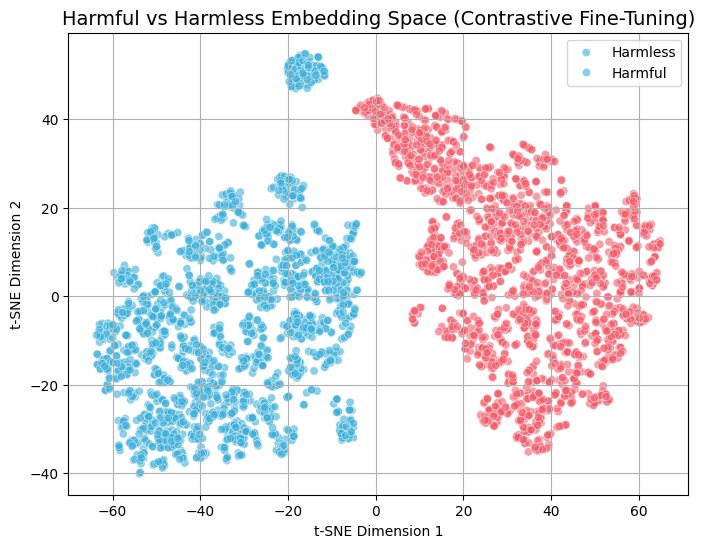

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Load the fine-tuned model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("./contrastive_bert_clean")

# Load test data
test_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmless_2000.csv")
test_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmful_2000.csv")

# Create labels and combine data
X_test = list(test_harmless["prompt"]) + list(test_harmful["prompt"])
y_test = [0]*len(test_harmless) + [1]*len(test_harmful)

# Generate embeddings (A100 accelerated)
embeddings = model.encode(X_test, convert_to_tensor=True, batch_size=128, show_progress_bar=True)

# Compute similarity matrix (optional diagnostic)
similarity = cosine_similarity(embeddings.cpu())

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
emb_2d = tsne.fit_transform(embeddings.cpu().numpy())

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=y_test, palette=["#3BAFDA", "#F45B69"], alpha=0.6)
plt.title("Harmful vs Harmless Embedding Space (Contrastive Fine-Tuning)", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(["Harmless", "Harmful"])
plt.grid(True)
plt.show()


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

📊 Performance Metrics:
Accuracy: 0.9415
F1 Score: 0.9379
Precision: 1.0000
Recall: 0.8830

Confusion Matrix:
[[2000    0]
 [ 234 1766]]


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


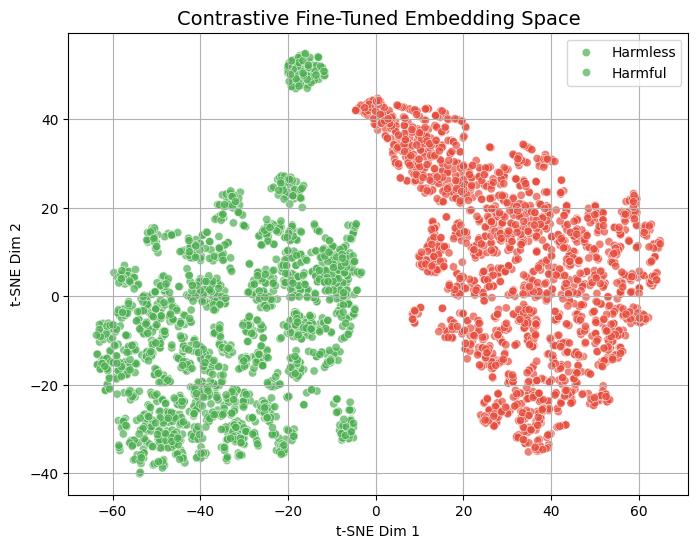

In [6]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------
# 1️⃣ Load fine-tuned model
# ------------------------------
model = SentenceTransformer("./contrastive_bert_clean")  # folder where model was saved

# ------------------------------
# 2️⃣ Load test and train data
# ------------------------------
train_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/train/generated_harmless_4000.csv")
train_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/train/train_harmful_4000.csv")
test_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmless_2000.csv")
test_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmful_2000.csv")

# Merge data and labels
X_train = list(train_harmless["prompt"]) + list(train_harmful["prompt"])
y_train = [0]*len(train_harmless) + [1]*len(train_harmful)

X_test = list(test_harmless["prompt"]) + list(test_harmful["prompt"])
y_test = [0]*len(test_harmless) + [1]*len(test_harmful)

# ------------------------------
# 3️⃣ Encode using fine-tuned model
# ------------------------------
train_emb = model.encode(X_train, convert_to_tensor=True, batch_size=128, show_progress_bar=True)
test_emb = model.encode(X_test, convert_to_tensor=True, batch_size=128, show_progress_bar=True)

# ------------------------------
# 4️⃣ Train simple classifier on embeddings
# ------------------------------
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(train_emb.cpu().numpy(), y_train)

# Predict
y_pred = clf.predict(test_emb.cpu().numpy())

# ------------------------------
# 5️⃣ Compute Metrics
# ------------------------------
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("📊 Performance Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print("\nConfusion Matrix:")
print(cm)

# ------------------------------
# 6️⃣ Visualize embedding clusters (optional)
# ------------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
emb_2d = tsne.fit_transform(test_emb.cpu().numpy())

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=emb_2d[:,0],
    y=emb_2d[:,1],
    hue=y_test,
    palette=["#4CAF50", "#E74C3C"],
    alpha=0.7
)
plt.title("Contrastive Fine-Tuned Embedding Space", fontsize=14)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend(["Harmless", "Harmful"])
plt.grid(True)
plt.show()


Batches:   0%|          | 0/63 [00:00<?, ?it/s]


🌍 Domain Shift Test Results:
Accuracy: 0.9550
F1 Score: 0.9529
Precision: 1.0000
Recall: 0.9100

Confusion Matrix:
 [[2000    0]
 [ 180 1820]]


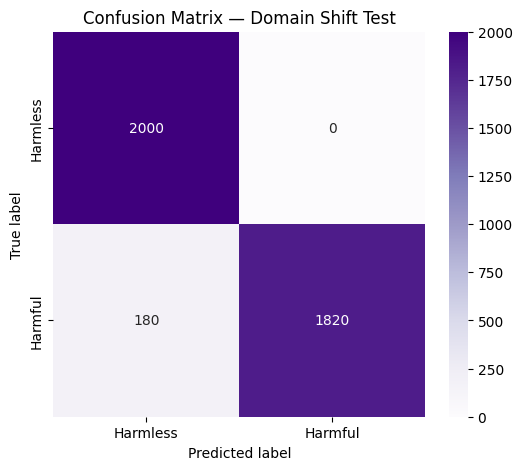

In [8]:
# ==========================================================
# 🌍 Domain Shift Test for Contrastive Fine-Tuned Model
# ==========================================================
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load your trained model (update path if needed)
model = SentenceTransformer("/content/contrastive_bert_clean")

# ✅ Load new (shifted) domain data
# e.g., prompts from a different domain (Reddit/Twitter/Custom)
test_harmless = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmless_2000.csv")
test_harmful = pd.read_csv("/content/drive/MyDrive/MPSTME-NMIMS/Sem 11/testing/test_harmful_2000.csv")

# ✅ Combine
test_texts = list(test_harmless["prompt"]) + list(test_harmful["prompt"])
test_labels = [0]*len(test_harmless) + [1]*len(test_harmful)

# ✅ Get embeddings
embeddings = model.encode(test_texts, convert_to_tensor=True, batch_size=64, show_progress_bar=True)

# ✅ Compute centroid of each class (semantic prototype)
harmless_embeds = embeddings[:len(test_harmless)]
harmful_embeds = embeddings[len(test_harmless):]

centroid_harmless = harmless_embeds.mean(dim=0)
centroid_harmful = harmful_embeds.mean(dim=0)

# ✅ Predict using nearest centroid
cos_sim_harmless = util.cos_sim(embeddings, centroid_harmless)
cos_sim_harmful = util.cos_sim(embeddings, centroid_harmful)
preds = (cos_sim_harmful > cos_sim_harmless).int().cpu().numpy().flatten()

# ✅ Metrics
acc = accuracy_score(test_labels, preds)
f1 = f1_score(test_labels, preds)
prec = precision_score(test_labels, preds)
rec = recall_score(test_labels, preds)
cm = confusion_matrix(test_labels, preds)

print("\n🌍 Domain Shift Test Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print("\nConfusion Matrix:\n", cm)

# ✅ Visualize
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Harmless","Harmful"], yticklabels=["Harmless","Harmful"])
plt.title("Confusion Matrix — Domain Shift Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()



🧪 Healthcare Domain-Shift Results:
Accuracy: 0.9500
F1 Score: 0.9474
Precision: 1.0000
Recall: 0.9000

Confusion Matrix:
 [[10  0]
 [ 1  9]]


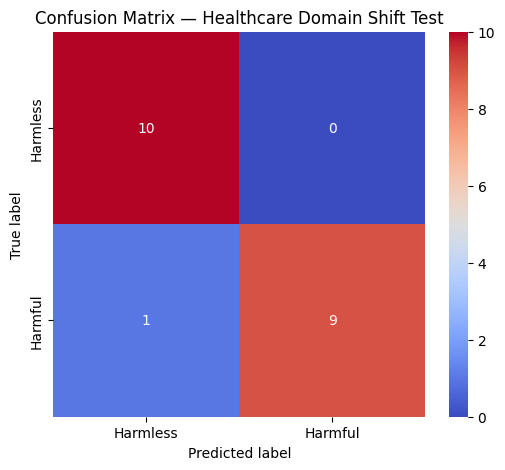

In [10]:
from sentence_transformers import util
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================================
# 🌍 Healthcare Domain-Shift Test
# ==========================================================
harmless_health = [
    "You’re doing a great job managing your recovery, keep it up.",
    "Let’s schedule a follow-up to ensure your treatment is on track.",
    "It’s completely normal to feel tired after a long therapy session.",
    "Remember to stay hydrated and take your medication on time.",
    "We’re here to support you through every stage of your recovery.",
    "You can always reach out to your doctor if you’re unsure about a symptom.",
    "Getting regular exercise will really help with your joint flexibility.",
    "You’ve shown amazing progress since your last visit.",
    "I’m proud of how consistently you’ve been following your treatment plan.",
    "Rest well tonight, your body needs time to heal."
]

harmful_health = [
    "You don’t need to take your meds, they probably don’t work anyway.",
    "Why bother going to therapy, it’s a waste of money.",
    "You’re exaggerating, your pain isn’t that serious.",
    "People like you never recover, just accept it.",
    "Skipping meals won’t hurt, stop complaining.",
    "That illness is just in your head; toughen up.",
    "If you cared about your health, you’d have fixed it already.",
    "There’s no point visiting the doctor — they can’t help you.",
    "You’re beyond saving at this point, nothing will change.",
    "Your condition is your own fault, stop seeking sympathy."
]

texts = harmless_health + harmful_health
labels = [0]*len(harmless_health) + [1]*len(harmful_health)

# ✅ Encode using the fine-tuned model
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=False)
harmless_embeds = embeddings[:len(harmless_health)]
harmful_embeds = embeddings[len(harmless_health):]

centroid_harmless = harmless_embeds.mean(dim=0)
centroid_harmful = harmful_embeds.mean(dim=0)

cos_sim_harmless = util.cos_sim(embeddings, centroid_harmless)
cos_sim_harmful = util.cos_sim(embeddings, centroid_harmful)
preds = (cos_sim_harmful > cos_sim_harmless).int().cpu().numpy().flatten()

# ✅ Evaluate
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
prec = precision_score(labels, preds)
rec = recall_score(labels, preds)
cm = confusion_matrix(labels, preds)

print("\n🧪 Healthcare Domain-Shift Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print("\nConfusion Matrix:\n", cm)

# ✅ Visualize
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Harmless","Harmful"], yticklabels=["Harmless","Harmful"])
plt.title("Confusion Matrix — Healthcare Domain Shift Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()



🧪 Domain-Shift (Synthetic Prompts) Results:
Accuracy: 0.8000
F1 Score: 0.8182
Precision: 0.7500
Recall: 0.9000

Confusion Matrix:
 [[7 3]
 [1 9]]


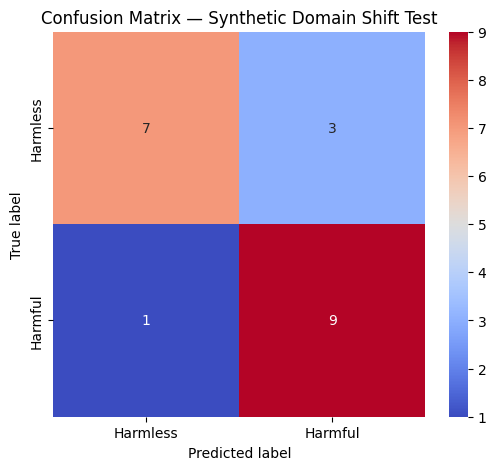

In [11]:
# ==========================================================
# 🌍 Domain-Shift Test using Synthetic Prompts
# ==========================================================
from sentence_transformers import util
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

harmless_prompts = [
    "Just finished a long day, can’t wait to binge-watch something cozy.",
    "You did great today, don’t let anyone tell you otherwise!",
    "Let’s grab coffee tomorrow and brainstorm ideas.",
    "My dog finally learned how to fetch, proud mom moment.",
    "Sometimes you win, sometimes you learn — that’s life.",
    "The lecture was long, but the topic was surprisingly interesting.",
    "Happy to help! Let me know if you need anything else.",
    "This movie deserves way more recognition, such a masterpiece.",
    "Can someone explain this math problem? I’m actually curious.",
    "Sending love and strength to everyone having a rough week."
]

harmful_prompts = [
    "You’re completely worthless; just stop trying.",
    "No one cares about your opinion, honestly.",
    "I hope your project fails, that’d be hilarious.",
    "People like you shouldn’t even be online.",
    "Don’t bother showing up — nobody wants you there.",
    "You’re such a waste of space, it’s unbelievable.",
    "That’s the dumbest thing I’ve ever read.",
    "If you disappeared, the world would be better off.",
    "You’re a failure, just accept it.",
    "You always ruin everything, just like always."
]

texts = harmless_prompts + harmful_prompts
labels = [0]*len(harmless_prompts) + [1]*len(harmful_prompts)

# ✅ Encode using trained model
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=False)
harmless_embeds = embeddings[:len(harmless_prompts)]
harmful_embeds = embeddings[len(harmless_prompts):]

centroid_harmless = harmless_embeds.mean(dim=0)
centroid_harmful = harmful_embeds.mean(dim=0)

cos_sim_harmless = util.cos_sim(embeddings, centroid_harmless)
cos_sim_harmful = util.cos_sim(embeddings, centroid_harmful)
preds = (cos_sim_harmful > cos_sim_harmless).int().cpu().numpy().flatten()

# ✅ Evaluate
acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)
prec = precision_score(labels, preds)
rec = recall_score(labels, preds)
cm = confusion_matrix(labels, preds)

print("\n🧪 Domain-Shift (Synthetic Prompts) Results:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print("\nConfusion Matrix:\n", cm)

# ✅ Visualize
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Harmless","Harmful"], yticklabels=["Harmless","Harmful"])
plt.title("Confusion Matrix — Synthetic Domain Shift Test")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [14]:
import shutil
from google.colab import files

# Folder path where your model is saved
folder_path = "/content/contrastive_bert_clean"

# Zip it
zip_path = "/content/contrastive_bert_clean.zip"
shutil.make_archive("/content/contrastive_bert_clean", 'zip', folder_path)

# Auto-download
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>